# Data Mining Workflow - Autoutuning
## with SAS VIYA

In [1]:
# Import necessary packages and modules
from swat import *
import pandas as pd
from matplotlib import pyplot as plt
import collections
%matplotlib inline

# Define directory and data file name
indata_dir = '/opt/sasinside/DemoData'
indata     = 'hmeq'

## Server, port, username, password
cashost='sasserver.demo.sas.com'
casport=5570
casauth='~/.authinfo'

# Server, port, username, password
s = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

# Load actionsets for analysis (for data prep, modeling, assessing)
actionsets = ['cardinality', 'sampling', 'fedSQL', 'decisionTree', 'neuralNet', 'svm', 'astore', 'autotune']
[s.builtins.loadactionset(i) for i in actionsets]

# Create a CAS library called DMLib pointing to the defined directory
## Note, need to specify the srctype is path, otherwise it defaults to HDFS
DMLib = s.table.addCaslib('DMlib', datasource = 'path', path = indata_dir)

# Push the relevant table In-Memory
## Note, this is a server side data load, not being loaded from the client
inMem = s.table.loadTable(indata + '.sas7bdat', casOut = indata)

NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'fedSQL'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'autotune'.
NOTE: 'DMlib' is now the active caslib.
NOTE: Cloud Analytic Services added the caslib 'DMlib'.
NOTE: Cloud Analytic Services made the file hmeq.sas7bdat available as table HMEQ in caslib DMlib.


# Data Exploration and Preparation

## Investigate the data - CAS

In [2]:
# Print out the first 10 rows of the dataset
s.CASTable(indata).head(10)

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN
5,1.0,1700.0,30548.0,40320.0,HomeImp,Other,9.0,0.0,0.0,101.466002,1.0,8.0,37.113614
6,1.0,1800.0,48649.0,57037.0,HomeImp,Other,5.0,3.0,2.0,77.100000,1.0,17.0,NaN
7,1.0,1800.0,28502.0,43034.0,HomeImp,Other,11.0,0.0,0.0,88.766030,0.0,8.0,36.884894
8,1.0,2000.0,32700.0,46740.0,HomeImp,Other,3.0,0.0,2.0,216.933333,1.0,12.0,NaN
9,1.0,2000.0,NaN,62250.0,HomeImp,Sales,16.0,0.0,0.0,115.800000,0.0,13.0,NaN


In [3]:
# Create table of summary statistics in SAS
s.CASTable(indata).cardinality.summarize(cardinality = dict(name = 'data_card', replace = True))
df_data_card = s.CASTable('data_card').to_frame() # bring the data locally

# Modify SAS output table using Python to present summary statistics
df_data_card['_PCTMISS_'] = (df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100
print('\n', 'Summary Statistics'.center(90, ' '))
df_data_card[['_VARNAME_','_TYPE_','_PCTMISS_','_MIN_','_MAX_','_MEAN_','_STDDEV_','_SKEWNESS_','_KURTOSIS_']].round(2)

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.000404148 seconds.

                                     Summary Statistics                                    


,_VARNAME_,_TYPE_,_PCTMISS_,_MIN_,_MAX_,_MEAN_,_STDDEV_,_SKEWNESS_,_KURTOSIS_
0,BAD,N,0.00,0.00,1.00,0.20,0.40,1.50,0.26
1,LOAN,N,0.00,1100.00,89900.00,18607.97,11207.48,2.02,6.93
2,MORTDUE,N,8.69,2063.00,399550.00,73760.82,44457.61,1.81,6.48
3,VALUE,N,1.88,8000.00,855909.00,101776.05,57385.78,3.05,24.36
4,REASON,C,4.23,NaN,NaN,NaN,NaN,NaN,NaN
5,JOB,C,4.68,NaN,NaN,NaN,NaN,NaN,NaN
6,YOJ,N,8.64,0.00,41.00,8.92,7.57,0.99,0.37
7,DEROG,N,11.88,0.00,10.00,0.25,0.85,5.32,36.87
8,DELINQ,N,9.73,0.00,15.00,0.45,1.13,4.02,23.57
9,CLAGE,N,5.17,0.00,1168.23,179.77,85.81,1.34,7.60


## Perform Imputation on Missing Values - CAS

In [4]:
# Impute missing values
s.dataPreprocess.impute(
    table             = indata,
    outVarsNamePrefix = 'IMP',
    methodContinuous  = 'MEDIAN',
    methodNominal     = 'MODE',
    inputs            = list(df_data_card['_VARNAME_'])[1:],
    copyAllVars       = True,
    casOut            = dict(name = indata, replace = True)
)

# Print the first five rows with imputations
s.CASTable(indata).head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,...,IMP_DEBTINC,IMP_DELINQ,IMP_DEROG,IMP_LOAN,IMP_MORTDUE,IMP_NINQ,IMP_VALUE,IMP_YOJ,IMP_JOB,IMP_REASON
0,1.0,1100.0,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,...,34.818262,0.0,0.0,1100.0,25860.0,1.0,39025.0,10.5,Other,HomeImp
1,1.0,1300.0,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,...,34.818262,2.0,0.0,1300.0,70053.0,0.0,68400.0,7.0,Other,HomeImp
2,1.0,1500.0,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,...,34.818262,0.0,0.0,1500.0,13500.0,1.0,16700.0,4.0,Other,HomeImp
3,1.0,1500.0,NaN,NaN,,,NaN,NaN,NaN,NaN,...,34.818262,0.0,0.0,1500.0,65019.0,1.0,89235.5,7.0,Other,DebtCon
4,0.0,1700.0,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,...,34.818262,0.0,0.0,1700.0,97800.0,0.0,112000.0,3.0,Office,HomeImp


## Partition Data into Training and Validation Sets - CAS

In [5]:
%%capture
# Create a 70/30 stratified split
s.sampling.stratified(
    table   = dict(name = indata, groupBy = df_data_card['_VARNAME_'][0]),
    samppct = 70,
    partind = True,
    seed    = 12345,
    output  = dict(casOut = dict(name = indata, replace = True), copyVars = 'ALL')
)


[outputSize]

 {'outputNObs': 5960.0, 'outputNVars': 26}

[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

   casLib  Name Label  Rows  Columns                          casTable
 0  DMlib  hmeq        5960       26  CASTable('hmeq', caslib='DMlib')

+ Elapsed: 0.0202s, user: 0.018s, sys: 0.003s, mem: 5.92mb

# Build Models

## Set Modeling Shortcuts - Python

### Models to be performed

In [6]:
# Models to be performed
models = collections.OrderedDict()
models['dt']  = 'Decision Tree'
models['gbt'] = 'Gradient Boosting'
models['nn']  = 'Neural Network'
models['svm'] = 'Support Vector Machine'

### Set variable shortcuts

In [7]:
# Set variables for later use by models
## For models that can handle missing values
target              = df_data_card['_VARNAME_'][0]
class_inputs        = list(df_data_card.query('_TYPE_ == "C"')['_VARNAME_'])
interval_inputs     = list(df_data_card.query('_TYPE_ == "N"')['_VARNAME_'])[1:]
class_vars          = [target] + class_inputs
all_inputs          = interval_inputs + class_inputs

## For models that can't handle missing values
imp_class_inputs    = ['IMP_' + s for s in class_inputs]
imp_interval_inputs = ['IMP_' + s for s in interval_inputs]
imp_class_vars      = [target] + imp_class_inputs
imp_all_inputs      = imp_interval_inputs + imp_class_inputs

### Set modeling argument shortcuts

In [8]:
def autotune_kwds(model):
    training_options = dict(table    = dict(name=indata, where = '_PartInd_ = 1'),
                            inputs   = all_inputs,
                            nominals = class_vars,
                            target   = target,
                            casout   = dict(name= model + 'opt', replace=True))
                            
    return training_options

def autotune_kwds_i(model):
    training_options = dict(table    = dict(name=indata, where = '_PartInd_ = 1'),
                            inputs   = imp_all_inputs,
                            nominals = imp_class_vars,
                            target   = target,
                            casout   = dict(name= model + 'opt', replace=True))
                            
    return training_options

## Decision Tree - CAS

In [9]:
s.invoke(
    'autotune.tuneDecisionTree', 
     trainOptions = autotune_kwds('dt'), 
     tunerOptions = dict(maxTime=60, userDefinedPartition = True),
     scoreOptions = dict(table = dict(name = indata, where = '_PartInd_ = 0'))
)

for response in s:
    for k, v in response:
        print(k, v)

NOTE: Autotune is started for 'Decision Tree' model.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=60 (sec.).
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: The SEED for autotune is 462586787.
         Iteration       Evals     Best Objective        Time
                 0           1             11.801        0.05
                 1          10             11.242        4.80
                 2          18             11.242        5.71
                 3          26             10.794        6.80
                 4          35             10.794        7.77
                 5          43             10.794       10.81
NOTE: Autotune time is 10.87 seconds.
ModelInfo Decision Tree for HMEQ

                           Descr       Value
0           Number of Tree Nodes   177.00000
1         Max Number of Branches     2.00000
2               Number of Levels    10.00000
3               Number of Leaves    89.00000
4                 Number of Bins

## Gradient Boosting - CAS

In [10]:
s.invoke(
    'autotune.tuneGradientBoostTree', 
     trainOptions=autotune_kwds('gbt'), 
     tunerOptions=dict(maxTime=60, userDefinedPartition = True),
     scoreOptions = dict(table = dict(name = indata, where = '_PartInd_ = 0')),
     tuningParameters=[dict(namePath='m', initValue=1)]
)

for response in s:
    for k, v in response:
        print(k, v)

NOTE: Autotune is started for 'Gradient Boosting Tree' model.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=60 (sec.).
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: The SEED for autotune is 462585670.
         Iteration       Evals     Best Objective        Time
                 0           1             9.0604        1.43
                 1          10              8.557       12.31
                 2          19             7.2707       21.62
                 3          28             7.2707       34.13
                 4          37             7.2707       45.01
                 5          46             7.2707       55.03
NOTE: Autotune time is 55.04 seconds.
ModelInfo Gradient Boosting Tree for HMEQ

                               Descr         Value
0                    Number of Trees  6.100000e+01
1                       Distribution  2.000000e+00
2                      Learning Rate  5.954568e-01
3                   Subsampling Rat

## Neural Network - CAS

In [11]:
s.invoke('autotune.tuneNeuralNet', 
          trainOptions=autotune_kwds_i('nn'), 
          tunerOptions=dict(maxTime=60, userDefinedPartition = True),
          scoreOptions = dict(table = dict(name = indata, where = '_PartInd_ = 0'))
)

for response in s:
    for k, v in response:
        print(k, v)

NOTE: Autotune is started for 'Neural Net' model.
NOTE: Autotune option MAXEVALS=50.
NOTE: Autotune option MAXTIME=60 (sec.).
NOTE: Autotune objective is 'Misclassification Error Percentage'.
NOTE: The SEED for autotune is 462580067.
         Iteration       Evals     Best Objective        Time
                 0           1             16.387        0.08
                 1          10             15.772        4.04
                 2          19             14.709        9.48
                 3          28             14.709       11.51
                 4          37             14.597       15.34
                 5          46             14.597       18.23
NOTE: Autotune time is 18.24 seconds.
OptIterHistory    Progress  Objective      Loss
0       1.0   3.992488  3.992487
1       2.0   1.820943  1.820941
2       3.0   1.659068  1.659066
3       4.0   1.577613  1.577611
4       5.0   1.554180  1.554178
5       6.0   1.533945  1.533944
6       7.0   1.506889  1.506887
7       8.0   1

## Support Vector Machine - CAS

In [12]:
#s.invoke('autotune.tuneSVM', trainOptions=autotune_kwds('svm'), 
                            #tunerOptions=dict(maxTime=60, validationPartitionFraction=0.3))
#for response in s:
 #   for k, v in response:
#      print(k, v)

# Model Comparison

## Score the Models on Validation Data - CAS/Python

In [13]:
%%capture
def score_model(model):
    score = dict(
        table      = indata,
        modelTable = model + 'opt',
        copyVars   = [target, '_partind_'],
        casOut     = dict(name = '_scored_' + model, replace = True)
    )
    return score

### Decision Tree
s.decisionTree.dtreeScore(**score_model('dt'))

### Gradient Boosting
s.decisionTree.gbtreeScore(**score_model('gbt'))

### Neural Network
s.neuralNet.annScore(**score_model('nn'))

### Support Vector Machine
#s.CASTable(indata).astore.score(rstore  = 'svm_model', out = dict(name = '_scored_svm', replace = True))

### Create standardized prediction column
for i in range(len(models)-1):
    s.dataStep.runCode('''
        data _scored_''' + list(models)[i] + '''; 
            set _scored_''' + list(models)[i] + '''; 
            if _''' + list(models)[i] + '''_predname_ = 1
                then p_''' + target + '''1 = _''' + list(models)[i] + '''_predp_; 
                else p_''' + target + '''1 = 1 - _''' + list(models)[i] + '''_predp_;
        run;
    ''')

## Assess the Performance - CAS/Python

In [14]:
# Model assessment function
def assess_model(model):
    assess = s.percentile.assess(
        table    = dict(name = '_scored_' + model, where = '_partind_ = 0'),
        inputs   = 'p_' + target + '1',      
        response = target,
        event    = '1',   
    )
    return assess

# Loop through the models and append to the roc_df dataframe
roc_df  = pd.DataFrame()
for i in range(len(models)-1):
    tmp = assess_model(list(models)[i])
    tmp.ROCInfo['Model']  = list(models.values())[i]
    roc_df  = pd.concat([roc_df,  tmp.ROCInfo])

# Display stacked confusion matrix using Python
print('\n', 'Confusion Matrix Information'.center(42, ' '))
roc_df[round(roc_df['CutOff'], 2) == 0.5][['Model', 'TP', 'FP', 'FN', 'TN']].reset_index(drop = True)


        Confusion Matrix Information       


,Model,TP,FP,FN,TN
0,Decision Tree,230.0,65.0,127.0,1366.0
1,Gradient Boosting,266.0,39.0,91.0,1392.0
2,Neural Network,137.0,41.0,220.0,1390.0


## Compare Misclassification Rates - Python

In [20]:
# Add misclassification rate calculation
roc_df['Misclassification'] = 1 - roc_df['ACC']

print('\n', 'Misclassification Rate Comparison'.center(37, ' '))
miss = roc_df[round(roc_df['CutOff'], 2)==0.5][['Model', 'Misclassification']]
miss.sort_values('Misclassification').reset_index(drop=True)


   Misclassification Rate Comparison  


,Model,Misclassification
0,Gradient Boosting,0.072707
1,Decision Tree,0.107383
2,Neural Network,0.145973


## Create ROC Curve - Python

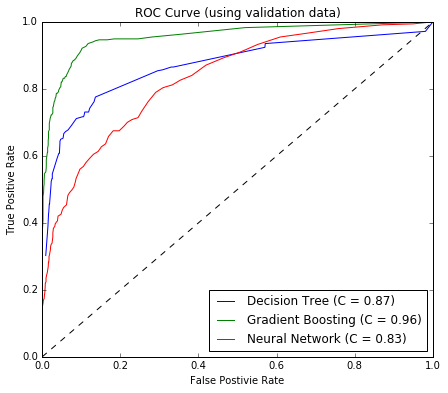

In [16]:
# Plot ROC curve
plt.figure(figsize = (7, 6))
for key, grp in roc_df.groupby(['Model']):
    plt.plot(grp['FPR'], grp['Sensitivity'], label = key + ' (C = %0.2f)' % grp['C'].mean())
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC Curve (using validation data)')
plt.show();

In [17]:
#s.session.endsession() # end the session